In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import category_encoders as ce
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge

In [39]:
# load dataset
dataset = pd.read_csv('dataset/spotify_tracks.csv')
dataset.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


### **Preprocessing**

In [40]:
# dataset.isnull().sum() # to check if there are missing values

# drop records with missing values
dataset.dropna(inplace=True)

In [41]:
dataset.nunique(axis=0) # to check the number of distinct values for each column

Unnamed: 0          113999
track_id             89740
artists              31437
album_name           46589
track_name           73608
popularity             101
duration_ms          50696
explicit                 2
danceability          1174
energy                2083
key                     12
loudness             19480
mode                     2
speechiness           1489
acousticness          5061
instrumentalness      5346
liveness              1722
valence               1790
tempo                45652
time_signature           5
track_genre            114
dtype: int64

In [42]:
X = dataset.drop(columns=['Unnamed: 0', 'track_id', 'popularity'])  # features
y = dataset['popularity']                                           # target variable

#### Feature encoding

***explicit*** is a binary categorical feature that we map it in {0,1}

In [43]:
X['explicit'] = X['explicit'].map({False : 0, True : 1})

***key*** and ***time_signature*** are categorical features with a restricted number of distinct values on which we apply one-hot encoding

In [44]:
ohe = ce.OneHotEncoder(cols=['key','time_signature']) 
X = ohe.fit_transform(X)

***artists***, ***album_name***, ***track_name*** and ***track_genre*** are categorical features with a large number of distinct values on which we apply binary encoding

In [45]:
be = ce.BinaryEncoder(cols=['artists', 'album_name', 'track_name', 'track_genre'])
X = be.fit_transform(X)

In [46]:
X.shape, X.columns

((113999, 84),
 Index(['artists_0', 'artists_1', 'artists_2', 'artists_3', 'artists_4',
        'artists_5', 'artists_6', 'artists_7', 'artists_8', 'artists_9',
        'artists_10', 'artists_11', 'artists_12', 'artists_13', 'artists_14',
        'album_name_0', 'album_name_1', 'album_name_2', 'album_name_3',
        'album_name_4', 'album_name_5', 'album_name_6', 'album_name_7',
        'album_name_8', 'album_name_9', 'album_name_10', 'album_name_11',
        'album_name_12', 'album_name_13', 'album_name_14', 'album_name_15',
        'track_name_0', 'track_name_1', 'track_name_2', 'track_name_3',
        'track_name_4', 'track_name_5', 'track_name_6', 'track_name_7',
        'track_name_8', 'track_name_9', 'track_name_10', 'track_name_11',
        'track_name_12', 'track_name_13', 'track_name_14', 'track_name_15',
        'track_name_16', 'duration_ms', 'explicit', 'danceability', 'energy',
        'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8',
        'key_9'

We split data in training and test set and we standardize them

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True) #stratify=y)

In [48]:
standard_scaler = preprocessing.StandardScaler().set_output(transform="pandas")

X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

# should I standardize also the target variable? boh, I don't think it's mandatory

We consider also the data corresponding only to numerical features of our dataset

In [49]:
numerical_features = ['duration_ms', 'explicit', 'danceability', 'energy', 'loudness', 'mode',
                      'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

X_train_numerical = X_train[numerical_features]
X_test_numerical = X_test[numerical_features]

In [50]:
X_train_numerical

,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
96253,1.209605,-0.306913,0.427460,0.950305,0.370570,-1.326874,-0.230378,-0.494867,-0.503032,2.086197,-0.196163,-0.971364
70417,0.032251,-0.306913,0.583241,-1.112037,-0.285686,-1.326874,-0.467827,1.441588,-0.505483,0.171212,-0.161413,-1.607835
66688,-1.199902,-0.306913,1.264062,-1.652458,-1.635483,0.753651,4.618883,1.092785,-0.505483,-0.064882,0.711186,-0.402106
51391,0.038294,-0.306913,0.819797,0.747647,0.486391,0.753651,1.515962,-0.739028,-0.505483,1.823870,0.695742,0.528133
95123,1.224293,-0.306913,1.264062,0.242990,0.302941,0.753651,-0.370388,0.587623,-0.505483,-0.489851,0.857906,-0.603445
...,...,...,...,...,...,...,...,...,...,...,...,...
76821,0.097276,-0.306913,-0.374524,-1.791537,-0.736874,0.753651,-0.458367,1.817453,2.257574,-0.679775,-1.250232,0.321024
110269,0.759202,-0.306913,-0.045653,1.125147,0.645051,0.753651,-0.164157,-0.917339,2.341303,3.413570,-1.312009,0.763428
103695,-0.848953,-0.306913,0.358224,-0.321274,-0.631762,-1.326874,-0.307005,0.840204,-0.505483,-0.164566,1.568341,-0.107604
860,-0.103603,-0.306913,-0.841867,-2.121352,-1.372703,0.753651,-0.484855,1.901646,-0.505483,-0.657215,-1.373786,-0.597174


In [51]:
X_test_numerical

,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
113186,1.964016,-0.306913,-1.141890,-0.170274,0.254946,0.753651,-0.514181,-0.933546,-0.505483,-0.196045,-1.649465,0.863697
42819,-1.241114,-0.306913,-2.284284,1.415226,0.928853,0.753651,0.314526,-0.933245,2.074015,1.084109,-1.715876,0.003406
59311,-0.133802,-0.306913,-2.272745,0.644332,-0.357281,-1.326874,0.560489,0.894329,-0.499332,-0.096361,-1.486915,-1.552964
90417,-0.752701,-0.306913,-0.853406,-1.028589,-1.025040,0.753651,-0.497153,0.013302,-0.505483,-0.563302,-0.045582,-1.265400
61000,0.076425,-0.306913,-0.068731,1.192700,0.986764,-1.326874,-0.346737,0.506437,-0.505483,0.276143,1.309650,-0.988476
...,...,...,...,...,...,...,...,...,...,...,...,...
83384,-0.132516,-0.306913,1.056354,-0.225905,-0.195250,0.753651,-0.486747,-0.902003,0.502485,-0.666659,-1.478034,0.028423
102335,0.413677,-0.306913,-0.639929,-1.882931,-0.649017,0.753651,-0.538778,1.597948,0.380112,-0.405906,-1.153706,0.673933
78411,-0.288804,-0.306913,0.427460,1.085411,1.202343,0.753651,0.004233,-0.661450,-0.505483,-1.070905,1.228568,0.265486
86528,0.645051,-0.306913,0.427460,0.437700,0.263871,0.753651,-0.418634,-0.892381,1.159436,0.475511,-0.041721,0.593745


In [52]:
X_train

,artists_0,artists_1,artists_2,artists_3,artists_4,artists_5,artists_6,artists_7,artists_8,artists_9,...,time_signature_3,time_signature_4,time_signature_5,track_genre_0,track_genre_1,track_genre_2,track_genre_3,track_genre_4,track_genre_5,track_genre_6
96253,1.138771,-0.804101,1.216131,-0.986895,1.102499,-0.984452,-0.983955,0.987545,1.014391,-1.019343,...,-0.093954,-0.126795,-0.037636,1.106143,1.111649,-0.899565,-0.981885,-0.982101,-0.998455,1.001679
70417,1.138771,-0.804101,1.216131,-0.986895,-0.907030,-0.984452,1.016306,0.987545,-0.985813,0.981024,...,-0.093954,-0.126795,-0.037636,1.106143,-0.899565,-0.899565,-0.981885,1.018225,1.001547,1.001679
66688,1.138771,-0.804101,-0.822280,1.013279,1.102499,-0.984452,1.016306,-1.012613,-0.985813,0.981024,...,-0.093954,-0.126795,-0.037636,1.106143,-0.899565,-0.899565,-0.981885,-0.982101,1.001547,1.001679
51391,1.138771,-0.804101,-0.822280,-0.986895,-0.907030,1.015794,-0.983955,-1.012613,-0.985813,0.981024,...,-0.093954,-0.126795,-0.037636,-0.904042,1.111649,1.111649,-0.981885,1.018225,-0.998455,-0.998324
95123,1.138771,1.243626,-0.822280,-0.986895,1.102499,1.015794,-0.983955,0.987545,1.014391,-1.019343,...,-0.093954,-0.126795,-0.037636,1.106143,1.111649,-0.899565,-0.981885,-0.982101,-0.998455,-0.998324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76821,1.138771,-0.804101,1.216131,-0.986895,1.102499,1.015794,-0.983955,-1.012613,-0.985813,0.981024,...,-0.093954,-0.126795,-0.037636,1.106143,-0.899565,-0.899565,1.018449,1.018225,-0.998455,1.001679
110269,1.138771,1.243626,1.216131,-0.986895,1.102499,-0.984452,1.016306,0.987545,-0.985813,0.981024,...,-0.093954,-0.126795,-0.037636,1.106143,1.111649,-0.899565,1.018449,1.018225,1.001547,1.001679
103695,1.138771,1.243626,-0.822280,-0.986895,-0.907030,1.015794,-0.983955,-1.012613,1.014391,-1.019343,...,-0.093954,-0.126795,-0.037636,1.106143,1.111649,-0.899565,1.018449,-0.982101,-0.998455,-0.998324
860,-0.878140,-0.804101,-0.822280,-0.986895,-0.907030,-0.984452,-0.983955,-1.012613,1.014391,-1.019343,...,-0.093954,-0.126795,-0.037636,-0.904042,-0.899565,-0.899565,-0.981885,-0.982101,-0.998455,1.001679


In [53]:
X_test

,artists_0,artists_1,artists_2,artists_3,artists_4,artists_5,artists_6,artists_7,artists_8,artists_9,...,time_signature_3,time_signature_4,time_signature_5,track_genre_0,track_genre_1,track_genre_2,track_genre_3,track_genre_4,track_genre_5,track_genre_6
113186,1.138771,1.243626,1.216131,1.013279,-0.907030,1.015794,-0.983955,-1.012613,-0.985813,-1.019343,...,-0.093954,-0.126795,-0.037636,1.106143,1.111649,1.111649,-0.981885,-0.982101,1.001547,-0.998324
42819,-0.878140,1.243626,1.216131,1.013279,-0.907030,-0.984452,-0.983955,0.987545,-0.985813,-1.019343,...,-0.093954,-0.126795,-0.037636,-0.904042,1.111649,-0.899565,1.018449,-0.982101,1.001547,1.001679
59311,1.138771,-0.804101,-0.822280,1.013279,-0.907030,-0.984452,-0.983955,-1.012613,-0.985813,0.981024,...,-0.093954,-0.126795,-0.037636,-0.904042,1.111649,1.111649,1.018449,1.018225,-0.998455,-0.998324
90417,-0.878140,-0.804101,-0.822280,1.013279,1.102499,-0.984452,1.016306,0.987545,1.014391,0.981024,...,-0.093954,-0.126795,-0.037636,1.106143,-0.899565,1.111649,1.018449,-0.982101,1.001547,1.001679
61000,1.138771,-0.804101,-0.822280,1.013279,-0.907030,-0.984452,1.016306,-1.012613,1.014391,0.981024,...,-0.093954,-0.126795,-0.037636,-0.904042,1.111649,1.111649,1.018449,1.018225,1.001547,-0.998324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83384,1.138771,-0.804101,1.216131,1.013279,1.102499,1.015794,1.016306,-1.012613,1.014391,-1.019343,...,-0.093954,-0.126795,-0.037636,1.106143,-0.899565,1.111649,-0.981885,1.018225,-0.998455,-0.998324
102335,1.138771,1.243626,-0.822280,1.013279,-0.907030,1.015794,1.016306,0.987545,-0.985813,0.981024,...,-0.093954,-0.126795,-0.037636,1.106143,1.111649,-0.899565,-0.981885,1.018225,1.001547,1.001679
78411,1.138771,-0.804101,1.216131,1.013279,-0.907030,-0.984452,1.016306,0.987545,-0.985813,-1.019343,...,-0.093954,-0.126795,-0.037636,1.106143,-0.899565,-0.899565,1.018449,1.018225,1.001547,1.001679
86528,-0.878140,-0.804101,-0.822280,-0.986895,-0.907030,1.015794,1.016306,0.987545,1.014391,-1.019343,...,-0.093954,-0.126795,-0.037636,1.106143,-0.899565,1.111649,-0.981885,1.018225,1.001547,1.001679


In [54]:
y_train

96253     41
70417     52
66688     11
51391     61
95123     37
          ..
76821     20
110269    28
103695     0
860       44
15795     55
Name: popularity, Length: 91199, dtype: int64

In [55]:
y_test

113186    50
42819     11
59311      0
90417     34
61000     57
          ..
83384     59
102335     0
78411     29
86528     42
96230     42
Name: popularity, Length: 22800, dtype: int64

### **Ridge Regression implementation**

In [56]:
class RidgeRegression:

    def __init__(self, alpha = 1.0):
        self._alpha = alpha
        self._w = None

    def fit(self, X, y):

        _X = X.copy()
        _X.insert(0, 'dummy_feature', 1)

        I = np.identity(_X.shape[1])
        I[0][0] = 0                         # justify this line

        self._w = np.linalg.inv(_X.T @ _X + self._alpha * I) @ _X.T @ y
        self._w.index = _X.columns


    def predict(self, X):

        if self._w is None:
            raise RuntimeError('Model is still to fit')
        
        _X = X.copy()
        _X.insert(0, 'dummy_feature', 1)
        
        y_prediction = _X @ self._w
        
        return y_prediction
    
    def get_params(self, deep=True):
        return {"alpha": self._alpha}
    """
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    """

In [57]:
class RidgeRegression2:

    def __init__(self, alpha = 1.0):
        self._alpha = alpha
        self._w = None

    def fit(self, X, y):

        #X_copy = X.copy(deep=False)

        X.insert(0, 'dummy_feature', 1)

        I = np.identity(X.shape[1])
        I[0][0] = 0                         # justify this line

        self._w = np.linalg.inv(X.T @ X + self._alpha * I) @ X.T @ y
        self._w.index = X.columns

        X.drop(columns='dummy_feature', inplace=True)


    def predict(self, X):

        if self._w is None:
            raise RuntimeError('Model is still to fit')
        
        #X_copy = X.copy(deep=False)

        X.insert(0, 'dummy_feature', 1)
        
        y_prediction = X @ self._w

        X.drop(columns='dummy_feature', inplace=True)
        
        return y_prediction

### **Ridge Regression test considering only numerical features**

In [58]:
x = []
y = []

for alpha in np.linspace(0.0, 400.0, num=10, endpoint=False):
    scores = cross_val_score(RidgeRegression(alpha), 
                             X_train_numerical, 
                             y_train, 
                             scoring='neg_mean_squared_error', 
                             cv=5)
    x.append(alpha)
    y.append(np.mean(scores))

best_lambda = x[y.index(max(y))]
best_lambda

KeyboardInterrupt: 

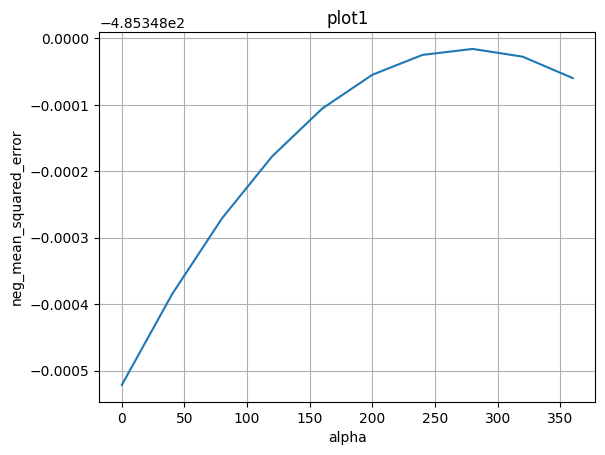

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='alpha', ylabel='neg_mean_squared_error',
       title='plot1')
ax.grid()

plt.show()

In [65]:
rr = RidgeRegression(best_lambda)
rr.fit(X_train_numerical, y_train)
y_prediction = rr.predict(X_test_numerical)

print(mean_squared_error(y_prediction, y_test))

485.58364614571894


In [ ]:
learner = GridSearchCV(estimator=Ridge(), 
                       param_grid={'alpha': np.linspace(0.0, 400.0, num=10, endpoint=False)}, 
                       cv=5, 
                       scoring='neg_mean_squared_error', 
                       return_train_score=True)
learner.fit(X_train_numerical, y_train)

learner.best_estimator_.fit(X_train_numerical, y_train)
y_prediction = learner.best_estimator_.predict(X_test_numerical)

print(mean_squared_error(y_prediction, y_test))

485.5765552369795


### **Ridge Regression test considering both numerical and categorical features**

In [ ]:
x = []
y = []

for alpha in np.linspace(0.0, 200.0, num=40, endpoint=False):
    scores = cross_val_score(RidgeRegression(alpha), 
                             X_train, 
                             y_train, 
                             scoring='neg_mean_squared_error', 
                             cv=5)
    x.append(alpha)
    y.append(np.mean(scores))

best_lambda = x[y.index(max(y))]
best_lambda

30.0

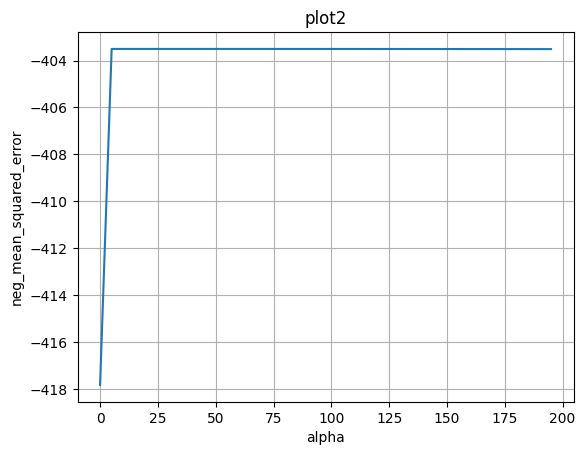

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='alpha', ylabel='neg_mean_squared_error',
       title='plot2')
ax.grid()

plt.show()

In [59]:
rr = RidgeRegression(best_lambda)
rr.fit(X_train, y_train)
y_prediction = rr.predict(X_test)

print(mean_squared_error(y_prediction, y_test))

404.7893600359107


In [ ]:
learner = GridSearchCV(estimator=Ridge(), 
                       param_grid={'alpha': np.linspace(0.0, 200.0, num=40, endpoint=False)}, 
                       cv=5, 
                       scoring='neg_mean_squared_error', 
                       return_train_score=True)
learner.fit(X_train, y_train)

learner.best_estimator_.fit(X_train, y_train)
y_prediction = learner.best_estimator_.predict(X_test)

print(learner.best_params_)
print(mean_squared_error(y_prediction, y_test))

KeyboardInterrupt: 

### **Kernel Ridge Regression implementation**

In [104]:
class KernelRidgeRegression:

    def __init__(self, α = 1.0, γ = 1.0):

        if α < 0: raise ValueError("α must be >= 0")
        if γ <= 0: raise ValueError("γ must be > 0")
        self._α = α
        self._γ = γ

        self._constant_term = None 
        self._x_i = None

    def gaussian_kernel(self, x_i, x_j):
        return np.exp(np.linalg.norm(x_i - x_j) / (-2 * self._γ))
    
    def fit(self, X, y):

        _X = X.copy()
        _X.insert(0, 'dummy_feature', 1)

        m = _X.shape[0]

        K = np.zeros((m, m))
        for i in range(m):
            for j in range(i, m):
                K[i][j] = self.gaussian_kernel(_X.iloc[i], _X.iloc[j])
                K[j][i] = K[i][j]
        
        I = np.identity(_X.shape[0])
        I[0][0] = 0                         # justify this line

        self._constant_term = y.T @ np.linalg.inv(K + self._α * I)
        self._x_i = _X
    
    def predict(self, X):

        if self._constant_term is None or self._x_i is None:
            raise RuntimeError('Model is still to fit')
        
        _X = X.copy()
        _X.insert(0, 'dummy_feature', 1)

        y_prediction = np.zeros(_X.shape[0])

        for i in range(len(y_prediction)):
            k_x = [self.gaussian_kernel(row, _X.iloc[i]) for _, row in self._x_i.iterrows()]
            y_prediction[i] = self._constant_term @ k_x

        return y_prediction
    
    
    def get_params(self, deep=True):
        return {"α": self._α, "γ": self._γ}
    """
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    """

In [110]:
class KernelRidgeRegression2:

    def __init__(self, α = 1.0, γ = 1.0):

        if α < 0: raise ValueError("α must be >= 0")
        if γ <= 0: raise ValueError("γ must be > 0")
        self._α = α
        self._γ = γ

        self._constant_term = None 
        self._x_i = None

    def gaussian_kernel(self, x_i, x_j):
        return np.exp(np.linalg.norm(x_i - x_j) / (-2 * self._γ))
    
    def fit(self, X, y):

        #_X = X.copy()
        #_X.insert(0, 'dummy_feature', 1)

        m = X.shape[0]

        _X = np.insert(X, 0, np.ones(m), axis=1)

        print(_X)



        

        K = np.zeros((m, m))
        for i in range(m):
            for j in range(i, m):
                K[i][j] = self.gaussian_kernel(_X.iloc[i], _X.iloc[j])
                K[j][i] = K[i][j]
        
        I = np.identity(_X.shape[0])
        I[0][0] = 0                         # justify this line

        self._constant_term = y.T @ np.linalg.inv(K + self._α * I)
        self._x_i = _X
    
    def predict(self, X):

        if self._constant_term is None or self._x_i is None:
            raise RuntimeError('Model is still to fit')
        
        _X = X.copy()
        _X.insert(0, 'dummy_feature', 1)

        y_prediction = np.zeros(_X.shape[0])

        for i in range(len(y_prediction)):
            k_x = [self.gaussian_kernel(row, _X.iloc[i]) for _, row in self._x_i.iterrows()]
            y_prediction[i] = self._constant_term @ k_x

        return y_prediction
    
    
    def get_params(self, deep=True):
        return {"α": self._α, "γ": self._γ}
    """
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    """

In [107]:
X_train_numerical_reduced = X_train_numerical.sample(n=300, random_state=1)
y_train_reduced = pd.Series( data = [y_train[i] for i, _ in X_train_numerical_reduced.iterrows()], 
                            index = [i for i, _ in X_train_numerical_reduced.iterrows()])

X_test_numerical_reduced = X_test_numerical.sample(n=100, random_state=1)
y_test_reduced = pd.Series( data = [y_test[i] for i, _ in X_test_numerical_reduced.iterrows()], 
                           index = [i for i, _ in X_test_numerical_reduced.iterrows()])

In [111]:
rr = KernelRidgeRegression2()
rr.fit(X_train_numerical_reduced.values, y_train_reduced.values)

[[ 1.         -0.9073335  -0.30691273 ... -0.67347962 -1.36606374
  -0.90285045]
 [ 1.         -0.41631037 -0.30691273 ...  0.76407055  1.7652549
   0.71275969]
 [ 1.          0.35530535 -0.30691273 ...  0.07677466 -0.200024
   0.32659434]
 ...
 [ 1.          0.38369039 -0.30691273 ... -0.24326388  1.41389855
  -0.68930372]
 [ 1.         -0.89769906  3.25825524 ... -0.43213908  1.04709797
  -0.67189175]
 [ 1.         -0.47338585 -0.30691273 ... -0.55805589 -0.75601646
  -0.53206234]]


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

array([[-0.9073335 , -0.30691273,  0.36399364, ..., -0.67347962,
        -1.36606374, -0.90285045],
       [-0.41631037, -0.30691273, -0.32836649, ...,  0.76407055,
         1.7652549 ,  0.71275969],
       [ 0.35530535, -0.30691273, -0.41491151, ...,  0.07677466,
        -0.200024  ,  0.32659434],
       ...,
       [ 0.38369039, -0.30691273,  0.88326375, ..., -0.24326388,
         1.41389855, -0.68930372],
       [-0.89769906,  3.25825524,  1.92180395, ..., -0.43213908,
         1.04709797, -0.67189175],
       [-0.47338585, -0.30691273,  1.1775168 , ..., -0.55805589,
        -0.75601646, -0.53206234]])

In [99]:
y_prediction = rr.predict(pd.DataFrame(X_test_numerical_reduced))

In [100]:
print(mean_squared_error(y_prediction, y_test_reduced))

540.0942602861622


In [101]:
y_prediction - y_test_reduced

43476    15.551067
50436    -3.626715
43867   -20.563564
27688     8.917089
62857   -11.063682
           ...    
61825    12.224850
49006   -26.267448
91042    37.986883
34829    -3.645929
25043   -15.619700
Length: 100, dtype: float64